<a href="https://colab.research.google.com/github/npradeep96/IDRBlocks/blob/master/IDR_LLM_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount data
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/ML_for_IDRs'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/ML_for_IDRs


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm
import h5py
import re

In [ ]:
!pip install lightning
import lightning as L
from lightning.pytorch import LightningModule
from lightning.pytorch.loggers import CSVLogger
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
torch.set_float32_matmul_precision(precision='medium')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 68.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

In [ ]:
!pip install optuna
!pip install optuna-integration
import optuna
from optuna_integration import PyTorchLightningPruningCallback

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 1.1 MB/s eta 0:00:00


# Load and prepare data matrix for ESM2 embeddings

In [ ]:
# Read embeddings
with h5py.File('/content/drive/My Drive/Colab Notebooks/ML_for_IDRs/esm2_embeddings.hdf5', "r") as f:
  esm2_embedding_matrix = np.array(f['esm2_embeddings'])

# Read labels [0/1 for included/excluded] from the csv file:

data_matrix = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_for_IDRs/data_matrix.csv')
# Select only the Uniprot IDs, sequences, and the partition ratios
selected_columns = ['Uniprot ID', 'Total IDR Length', 'Log Partition Ratios']
data_matrix = data_matrix[selected_columns]
# Select only the protein sequences that have a partition ratio of > 2 or < -2 for classification
def assign_labels(pr):
  if pr > 1.0:
    return 1
  elif pr < -1.0:
    return 0
  else:
    return -1
data_matrix['Enrichment Label'] = data_matrix['Log Partition Ratios'].apply(assign_labels)
# Drop the columns that contain Enrichment Label of -1
data_matrix.drop(data_matrix[data_matrix['Enrichment Label'] == -1].index, inplace=True)
# Drop the IDR sequences that have a length larger than 650 as my LLM starts
# struggling to generate embeddings with 16 GB RAM
data_matrix.drop(data_matrix[data_matrix['Total IDR Length'] > 650.0].index, inplace=True)
labels = data_matrix['Enrichment Label']


In [ ]:
print(np.shape(esm2_embedding_matrix))
print(len(labels))

(1315, 1280)
1315


In [ ]:
# Scale the data from
X = esm2_embedding_matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X=X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.describe()

# Do a test:train 20:80 split
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled.iloc[:,:], labels, test_size=0.2, train_size=0.8)

# Divide the train set into a validation:train 20:80 split
X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, train_size=0.8)

# Dataset class
class IDRFeaturesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(np.array(X))  # store X as a pytorch Tensor
        self.y = torch.Tensor(np.array(y))  # store y as a pytorch Tensor
        self.len = len(self.X)              # number of samples in the data

    def __getitem__(self, index):
        # your implementation here:
        return self.X[index], self.y[index]
    def __len__(self):
        return self.len

# Build Dataset
train_data = IDRFeaturesDataset(X_train, y_train) # fill in code here
val_data = IDRFeaturesDataset(X_val, y_val) # fill in code here
test_data = IDRFeaturesDataset(X_test, y_test) # fill in code here

# Train model

In [ ]:
# Define the neural network model using PyTorch Lightning
class BinaryClassifier(LightningModule):
    def __init__(self, lr=0.001, dropout_rate=0.5, weight_decay=1e-5, embedding_dim=1280):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, 64)  # Fully connected layer
        self.fc3 = nn.Linear(64, 16)  # Fully connected layer
        self.fc4 = nn.Linear(16, 16)  # Fully connected layer
        self.fc5 = nn.Linear(16, 1)    # Output layer

        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.dropout_half = nn.Dropout(0.5)  # Dropout layer for dim reduction

        self.lr = lr # Learning rate
        self.weight_decay = weight_decay # L2 regularization coefficient

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout_half(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout_half(x)  # Apply dropout
        x = F.relu(self.fc3(x))
        x = self.dropout_half(x)  # Apply dropout
        x = F.relu(self.fc4(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc4(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc4(x))
        x = self.dropout(x)  # Apply dropout
        x = torch.sigmoid(self.fc5(x))
        return x

    def training_step(self, batch, batch_idx):
        embeddings, labels = batch
        outputs = self(embeddings)
        loss = F.binary_cross_entropy(outputs.squeeze(), labels.squeeze())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        embeddings, labels = batch
        outputs = self(embeddings)
        loss = F.binary_cross_entropy(outputs.squeeze(), labels.squeeze())
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        embeddings, labels = batch
        outputs = self(embeddings)
        loss = F.binary_cross_entropy(outputs.squeeze(), labels.squeeze())
        conf_matrix = confusion_matrix(labels.squeeze(), outputs.squeeze())
        self.log('val_loss', loss)
        self.log('test_acc', accuracy_score(labels.squeeze(), outputs.squeeze()))
        self.log('confusion_matrix', conf_matrix)
        return loss

    def configure_optimizers(self):
        # Add weight decay for L2 regularization
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr,
                                     weight_decay=self.weight_decay)
        return optimizer

In [ ]:
# def objective(trial):

#     # Tune learning rates and regularization hyperparameters
#     params = {"dropout_rate": trial.suggest_float("dropout_rate", 0.1, 0.5, log=True),
#               "lr": trial.suggest_float("lr", 1e-3, 0.1, log=True),
#               "weight_decay": trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)}
#     # Tune max epochs
#     max_epochs =  trial.suggest_int("max_epochs", 50, 200)
#     # Tune batch size
#     log_2_batch_size =  trial.suggest_int("log_2_batch_size", 3, 5)
#     # Build DataLoader
#     batch_size = 2**log_2_batch_size
#     train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

#     ffn = BinaryClassifier(**params)
#     logger = CSVLogger("logs", name="model")

#     trainer = L.Trainer(
#         logger=logger,
#         enable_checkpointing=True,
#         callbacks=[L.pytorch.callbacks.ModelCheckpoint(dirpath="checkpoints")],
#         enable_progress_bar=False,
#         accelerator="gpu",
#         devices=1,
#         max_epochs=max_epochs, # number of epochs to train for
#     )

#     hyperparameters = dict(max_epochs=max_epochs, **params)
#     trainer.logger.log_hyperparams(hyperparameters)
#     trainer.fit(ffn, train_loader, val_loader)  # Define your dataloaders properly

#     return trainer.callback_metrics["val_loss"].item()  # Or any other metric that you aim to minimize

# # Create a study and execute optimization
# pruner = optuna.pruners.PatientPruner(optuna.pruners.HyperbandPruner(), patience=3)
# study = optuna.create_study(direction="minimize", pruner=pruner)
# study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# print("Best trial:")
# trial = study.best_trial
# print(f"  Value: {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# Performance of the best ESM2 model

In [ ]:
# Performance of the best model

max_epochs = 71
batch_size = 8
weight_decay = 0.001617
lr = 0.003128671
dropout_rate = 0.1369

# max_epochs = 100
# batch_size = 32
# weight_decay = 0.005
# lr = 0.003
# dropout_rate = 0.25

# max_epochs = 58
# batch_size = 8
# weight_decay = 0.0039934
# lr = 0.0017
# dropout_rate = 0.36132

# Creating data loaders for each set
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Initialize the model
model = BinaryClassifier(lr=lr, weight_decay=weight_decay, dropout_rate=dropout_rate)

# Initialize the trainer
logger = CSVLogger("logs", name="model_esm2_best")
trainer = L.Trainer(logger=logger, accelerator="gpu", devices=1, max_epochs=max_epochs, log_every_n_steps=10)

# Train the model
trainer.fit(model, train_loader, val_loader)

print(trainer.logger)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type    | Params
-----------------------------------------
0 | fc1          | Linear  | 327 K 
1 | fc2          | Linear  | 16.4 K
2 | fc3          | Linear  | 1.0 K 
3 | fc4          | Linear  | 272   
4 | fc5          | Linear  | 17    
5 | dropout      | Dropout | 0     
6 | dropout_half | Dropout | 0     
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=71` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=71` reached.


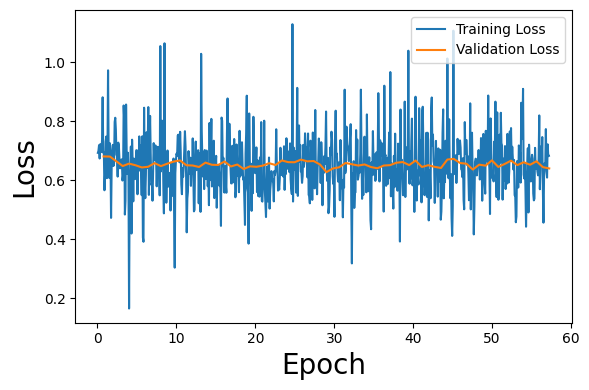

In [ ]:
# Look at training performance

train_set_size = 1052 # 0.8*1315

log_directory = '/content/drive/My Drive/Colab Notebooks/ML_for_IDRs/logs/model_esm2_best/version_8/metrics.csv'
df = pd.read_csv(log_directory)
df.head(10)

df_train_loss = df.dropna(subset=['train_loss'])
df_val_loss = df.dropna(subset=['val_loss'])

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.divide(batch_size*np.array(df_train_loss['step']), train_set_size),
        df_train_loss['train_loss'], label='Training Loss')
ax.plot(np.divide(batch_size*np.array(df_val_loss['step']), train_set_size),
        df_val_loss['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.legend(loc='upper right')
fig.tight_layout()
plt.savefig('ESM2_best_training_curve', format='png')
plt.show()
plt.close()

Test Cross entropy: 0.6499
Test Accuracy: 0.635
Test AUROC: 0.682
Confusion Matrix:
[[96 35]
 [61 71]]


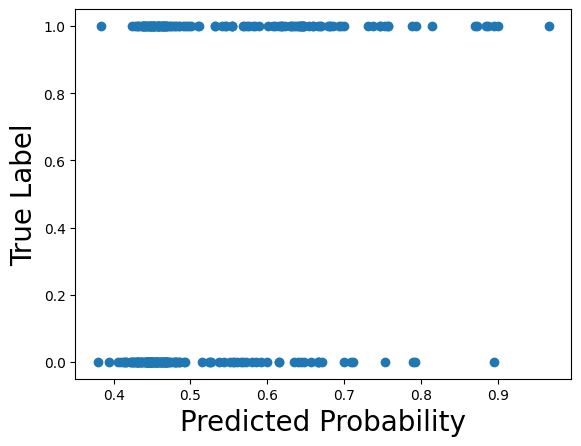

In [ ]:
# Evaluate the model on test data
test_loader = DataLoader(test_data, batch_size=batch_size)

# Calculate AUROC
y_true = []
y_scores = []
for batch in test_loader:
    x, y = batch
    y_true.extend(y.numpy())
    y_scores.extend(model(x).detach().numpy())

auroc = roc_auc_score(y_true, y_scores)
accuracy = accuracy_score(y_true, np.round(np.array(y_scores)))
conf_matrix = confusion_matrix(y_true, np.round(np.array(y_scores)))
cross_entropy = F.binary_cross_entropy(torch.tensor(y_scores).squeeze(), torch.tensor(y_true).squeeze())
#
print(f"Test Cross entropy: {cross_entropy:.4f}")
print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test AUROC: {auroc:.3f}")
print("Confusion Matrix:")
print(conf_matrix)

plt.scatter(y_scores, y_true)
plt.xlabel('Predicted Probability', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.savefig('ESM2_best_y_pred_vs_y_label', format='png')
plt.show()
plt.close()

# Load and prepare data matrix for ProtTrans embeddings

In [ ]:
# Read embeddings
with h5py.File('/content/drive/My Drive/Colab Notebooks/ML_for_IDRs/prottrans_embeddings.hdf5', "r") as f:
  prottrans_embedding_matrix = np.array(f['prottrans_embeddings'])

# Read labels [0/1 for included/excluded] from the csv file:

data_matrix = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML_for_IDRs/data_matrix.csv')
# Select only the Uniprot IDs, sequences, and the partition ratios
selected_columns = ['Uniprot ID', 'Total IDR Length', 'Log Partition Ratios']
data_matrix = data_matrix[selected_columns]
# Select only the protein sequences that have a partition ratio of > 2 or < -2 for classification
def assign_labels(pr):
  if pr > 1.0:
    return 1
  elif pr < -1.0:
    return 0
  else:
    return -1
data_matrix['Enrichment Label'] = data_matrix['Log Partition Ratios'].apply(assign_labels)
# Drop the columns that contain Enrichment Label of -1
data_matrix.drop(data_matrix[data_matrix['Enrichment Label'] == -1].index, inplace=True)
# Drop the IDR sequences that have a length larger than 650 as my LLM starts
# struggling to generate embeddings with 16 GB RAM
data_matrix.drop(data_matrix[data_matrix['Total IDR Length'] > 650.0].index, inplace=True)
labels = data_matrix['Enrichment Label']


In [ ]:
print(np.shape(prottrans_embedding_matrix))
print(len(labels))

(1315, 1024)
1315


In [ ]:
# Scale the data from
X = prottrans_embedding_matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X=X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.describe()

# Do a test:train 20:80 split
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled.iloc[:,:], labels, test_size=0.2, train_size=0.8)

# Divide the train set into a validation:train 20:80 split
X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, train_size=0.8)

# Dataset class
class IDRFeaturesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(np.array(X))  # store X as a pytorch Tensor
        self.y = torch.Tensor(np.array(y))  # store y as a pytorch Tensor
        self.len = len(self.X)              # number of samples in the data

    def __getitem__(self, index):
        # your implementation here:
        return self.X[index], self.y[index]
    def __len__(self):
        return self.len

# Build Dataset
train_data = IDRFeaturesDataset(X_train, y_train) # fill in code here
val_data = IDRFeaturesDataset(X_val, y_val) # fill in code here
test_data = IDRFeaturesDataset(X_test, y_test) # fill in code here

# Train model

In [ ]:
def objective(trial):

    # Tune learning rates and regularization hyperparameters
    params = {"dropout_rate": trial.suggest_float("dropout_rate", 0.1, 0.5, log=True),
              "lr": trial.suggest_float("lr", 1e-3, 0.1, log=True),
              "weight_decay": trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True),
              "embedding_dim": 1024}
    # Tune max epochs
    max_epochs =  trial.suggest_int("max_epochs", 50, 200)
    # Tune batch size
    log_2_batch_size =  trial.suggest_int("log_2_batch_size", 3, 5)
    # Build DataLoader
    batch_size = 2**log_2_batch_size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    ffn = BinaryClassifier(**params)
    logger = CSVLogger("logs", name="model")

    trainer = L.Trainer(
        logger=logger,
        enable_checkpointing=True,
        callbacks=[L.pytorch.callbacks.ModelCheckpoint(dirpath="checkpoints")],
        enable_progress_bar=False,
        accelerator="gpu",
        devices=1,
        max_epochs=max_epochs, # number of epochs to train for
    )

    hyperparameters = dict(max_epochs=max_epochs, **params)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(ffn, train_loader, val_loader)  # Define your dataloaders properly

    return trainer.callback_metrics["val_loss"].item()  # Or any other metric that you aim to minimize

# Create a study and execute optimization
pruner = optuna.pruners.PatientPruner(optuna.pruners.HyperbandPruner(), patience=3)
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

<ipython-input-11-af382c3dabd7>:37: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner = optuna.pruners.PatientPruner(optuna.pruners.HyperbandPruner(), patience=3)
[I 2024-05-19 20:11:37,235] A new study created in memory with name: no-name-b7334f37-3a1b-4237-9afd-69f0b53cce6a
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  

Best trial:
  Value: 0.6135501265525818
  Params: 
    dropout_rate: 0.20486382774574227
    lr: 0.0036737630169954402
    weight_decay: 0.0032976059593224725
    max_epochs: 85
    log_2_batch_size: 5


# Evaluating the best model

In [ ]:
# Performance of the best model

max_epochs = 85
batch_size = 32
weight_decay = 0.0032976059593224725
lr = 0.0036737630169954402
dropout_rate = 0.20486382774574227

# max_epochs = 100
# batch_size = 32
# weight_decay = 0.005
# lr = 0.003
# dropout_rate = 0.25

# max_epochs = 58
# batch_size = 8
# weight_decay = 0.0039934
# lr = 0.0017
# dropout_rate = 0.36132

# Creating data loaders for each set
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Initialize the model
model = BinaryClassifier(lr=lr, weight_decay=weight_decay, dropout_rate=dropout_rate, embedding_dim=1024)

# Initialize the trainer
logger = CSVLogger("logs", name="model_prottrans_best")
trainer = L.Trainer(logger=logger, accelerator="gpu", devices=1, max_epochs=max_epochs, log_every_n_steps=10)

# Train the model
trainer.fit(model, train_loader, val_loader)

print(trainer.logger)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type    | Params
-----------------------------------------
0 | fc1          | Linear  | 262 K 
1 | fc2          | Linear  | 16.4 K
2 | fc3          | Linear  | 1.0 K 
3 | fc4          | Linear  | 272   
4 | fc5          | Linear  | 17    
5 | dropout      | Dropout | 0     
6 | dropout_half | Dropout | 0     
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=85` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=85` reached.


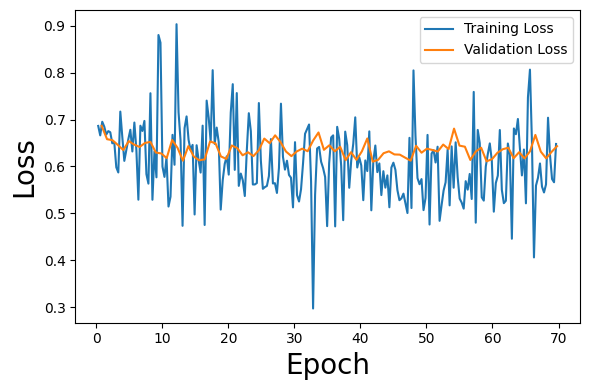

In [ ]:
# Look at training performance

train_set_size = 1052 # 0.8*1315

log_directory = '/content/drive/My Drive/Colab Notebooks/ML_for_IDRs/logs/model_prottrans_best/version_0/metrics.csv'
df = pd.read_csv(log_directory)
df.head(10)

df_train_loss = df.dropna(subset=['train_loss'])
df_val_loss = df.dropna(subset=['val_loss'])

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(np.divide(batch_size*np.array(df_train_loss['step']), train_set_size),
        df_train_loss['train_loss'], label='Training Loss')
ax.plot(np.divide(batch_size*np.array(df_val_loss['step']), train_set_size),
        df_val_loss['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.legend(loc='upper right')
fig.tight_layout()
plt.savefig('ProtTrans_best_training_curve', format='png')
plt.show()
plt.close()

In [ ]:
# Evaluate the model on test data
test_loader = DataLoader(test_data, batch_size=batch_size)

# Calculate AUROC
y_true = []
y_scores = []
for batch in test_loader:
    x, y = batch
    y_true.extend(y.numpy())
    y_scores.extend(model(x).detach().numpy())

auroc = roc_auc_score(y_true, y_scores)
accuracy = accuracy_score(y_true, np.round(np.array(y_scores)))
conf_matrix = confusion_matrix(y_true, np.round(np.array(y_scores)))
cross_entropy = F.binary_cross_entropy(torch.tensor(y_scores).squeeze(), torch.tensor(y_true).squeeze())
#
print(f"Test Cross entropy: {cross_entropy:.4f}")
print(f"Test Accuracy: {accuracy:.3f}")
print(f"Test AUROC: {auroc:.3f}")
print("Confusion Matrix:")
print(conf_matrix)

plt.scatter(y_scores, y_true)
plt.xlabel('Predicted Probability', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.savefig('ProtTrans_best_y_pred_vs_y_label', format='png')
plt.show()
plt.close()

NameError: name 'DataLoader' is not defined